# Finite Element Surrogate Modelling

A block is subject to external heating conditions and the corresponding temperature is desired to be known as a function of time. Data has been collected across different scenarios and time points for the same block using finite element modelling. However, this is expensive and there is a desire to produce a surrogate model to make block temperature predictions rapidly.

However, the use of a surrogate model adds additional uncertainty to the block's thermal response. Additionally, there is epistemic uncertainty (from gaps in the data base where the block's thermal response is un-tested) and aleatoric uncertainty (due to the natural variation and ucnertainty in the collected data) This uncertainty has to be captured to understand the trust-worthyness of the results. A Gaussian Process (GP) surrogate model is tasked with quantifying this uncertainty and propagating the uncertainty throughout the time evolution.

The Gaussian process (GP) model aim is to predict the temperature at the next time point, $t_{i+1}$, given the external heating conditions and the temperature at the current time point, $t_i$.

![Model Setup](assets/Model%20Setup.png)

Since the temperature is required at a large number of spatial locations (4096), dimensionality reduction is applied to enable learning and prediction in a reduced-dimensional latent space. Owing to the smoothness of the temperature field, principal component analysis (PCA) shows that the majority of the variance can be captured by a small number of principal components. A PCA basis is therefore constructed to provide a linear mapping between the full temperature field and the latent space.

In this notebook, data from ~40 scenarios across many time points is collated. Some of the are omitted for subsequent validation purposes. The data is reformatted into inputs:
 - the external heating conditions,
 - the block temperature *t_lag* seconds ago,
and outputs:
 - the current block temperature.

*t_lag* is defined by the user as a trade-off between sufficient time to enable the external heating conditions to have an influence and not so long such that the block loses memory as to its previous state.

## Notebook steps
This notebook follows four stages: setup, data preparation, cloud training, and local evaluation/visualisation.


# 0. Imports and Setup

Install dependencies, import libraries, load environment variables, and authenticate with the Uncertainty Engine.


In [1]:
!pip install -r  requirements.txt --quiet


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import re
import os
from pathlib import Path
import csv
import numpy as np
import pandas as pd
import torch
import pyvista as pv
import urllib.request
import requests
from pprint import pprint
from bisect import bisect_right
from typing import Tuple, Dict, Union
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sklearn.decomposition import TruncatedSVD
import zipfile, tempfile
from __future__ import annotations
from dataclasses import dataclass

import uncertainty_engine as engine


In [3]:
# automatically load .env in current directory
load_dotenv()

True

We can now tell the Uncertainty Engine who we are and which project we want to work in. For now, we will assume your personal project, but you can add a new project using the GUI: https://uncertaintyengine.ai/

In [4]:
client = engine.Client()
client.authenticate()
PROJECT_NAME = "Personal"

You can test your Engine access by viewing your projects. Occasionally (typically installing python on mac os directly from python), an access error will be raised. Run the cell titled mac os error catch to circumvent this.

In [5]:
try:
    pprint(client.projects.list_projects())
except Exception as e:
    # mac os error catch
    import os, certifi
    os.environ["SSL_CERT_FILE"] = certifi.where()

    pprint(client.projects.list_projects())

[ProjectRecordOutput(id='68dd8860e889afed3bc941a0', name='Personal', owner_id='689b17125d033ce54adfffe9', description=None, members={}, created_at=datetime.datetime(2025, 10, 1, 20, 0, 32, 856000), updated_at=datetime.datetime(2025, 10, 1, 20, 0, 32, 856000)),
 ProjectRecordOutput(id='68dfc0b9e889afed3bc9427d', name='Demos', owner_id='689b17125d033ce54adfffe9', description=None, members={}, created_at=datetime.datetime(2025, 10, 3, 12, 25, 29, 984000), updated_at=datetime.datetime(2025, 10, 3, 12, 25, 29, 984000)),
 ProjectRecordOutput(id='68e651ebd39c3b992766e54d', name='NeutronicsActivation', owner_id='689b17125d033ce54adfffe9', description=None, members={}, created_at=datetime.datetime(2025, 10, 8, 11, 58, 35, 181000), updated_at=datetime.datetime(2025, 10, 8, 11, 58, 35, 181000)),
 ProjectRecordOutput(id='68e6d39cd39c3b992766e651', name='Corrosion', owner_id='689b17125d033ce54adfffe9', description=None, members={}, created_at=datetime.datetime(2025, 10, 8, 21, 11, 56, 516000), upda

In [6]:
# colours
INDIGO = "#16425B"
KEPPEL = "#16D5C2"
KEY_LIME = "#EBF38B"

# 1. Data Preparation

Configure constants and paths, normalize input CSVs, collate paired scenarios, build a lagged latent dataset, and upload the resulting datasets to the Engine.


In [7]:
box_details_filename = 'Cube_dyn_rom.wbpz' # add this to the directory
n_retained_dimensions = 6
lag_time = 1  # seconds
n_retained_rows = 1000

In [8]:
models_directory = 'models'
data_directory = 'data'
raw_data_directory = f'{data_directory}{os.sep}IN_OUT'
input_filename = 'collated_inputs'
output_filename = 'collated_outputs'
pca_filename = 'pca_matrix'

external_conditions_input_names = ['Convection_FilmCoef', 'Heat Flux_Magnitude',	'Convection_AmbientTemp']

In [9]:
output_column_names = [f"T_latent_{i}" for i in range(n_retained_dimensions)]
save_model_names = output_column_names

In [10]:
def read_auto_csv(filepath, is_overwrite=False):
    with open(filepath, 'r', newline='', encoding='utf-8') as f:
        sample = f.read(2048)  # small chunk to analyse

    # Detect the delimiter
    dialect = csv.Sniffer().sniff(sample, delimiters=[',',';','\t'])
    delimiter = dialect.delimiter
    df = pd.read_csv(filepath, delimiter=delimiter)
    if delimiter != ',' and is_overwrite:
        print(f"saving: {filepath}")
        df.to_csv(filepath, index=False)
    return df

In [11]:
is_clean = True
if is_clean:
    # Folder path
    folder = Path(raw_data_directory)
    # Iterate through matching files
    for file in folder.glob('*.csv'):
        read_auto_csv(file, is_overwrite=True)

In [12]:
def load_numeric_csv(filepath):
    df = pd.read_csv(filepath)
    print(f"Processing: {filepath}")
    print(f"\t shape: {df.shape}")
    df.columns = df.columns.str.strip()

    df_numeric = df.apply(pd.to_numeric, errors="coerce")
    non_numeric_cols = df.columns[(df_numeric.isna() & df.notna()).any()]
    if len(non_numeric_cols) > 0:
        print(f"Non-numeric column(s) found, dropping:", list(non_numeric_cols))
        df = df.drop(columns=list(non_numeric_cols))

    return df


def make_input_features_from_file(
    filepath,
    time_col: str = "Time",
    input_cols=external_conditions_input_names,
):
    """
    Load input features from a CSV and return:
        [Time, input_cols..., source_file]

    No rolling time windows, just the original values.
    """
    df = load_numeric_csv(filepath)

    # Check required columns
    required = list(input_cols) + [time_col]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in {filepath}: {missing}")

    # Keep only Time + input columns (in a controlled order)
    feats = df[[time_col, *input_cols]].copy()

    # Optional: drop first row to match previous convention
    # (e.g. if outputs lose the first row due to diffs/lag)
    feats = feats.iloc[1:].copy()

    # Keep track of source file
    feats["source_file"] = Path(filepath).name

    # Reset index to simple 0..N-1
    return feats.reset_index(drop=True)


def make_output_features_from_file(
    filepath,
    time_col="Time",
    temp_cols=None,
):
    """
    Return raw temperature fields (no derivatives).

    Each row = one time step for this simulation.
    Columns = all temperature vertices + Time + source_file.
    """
    df = load_numeric_csv(filepath)

    if time_col not in df.columns:
        raise ValueError(f"{time_col} column is required in {filepath}")

    # Auto-detect temperature columns if not provided
    if temp_cols is None:
        temp_cols = [c for c in df.columns if c != time_col]

    # TimedeltaIndex (mainly for consistency; not strictly needed here)
    t = pd.to_timedelta(df[time_col].values, unit="s")
    df_time = df.set_index(t)

    out = df_time[temp_cols].copy()

    # Add aligned time and source
    out[time_col] = df_time[time_col].values
    out["source_file"] = Path(filepath).name

    return out.reset_index(drop=True)


In [13]:
def extract_number(path: Path):
    """
    Extract the digits between '_' and '_' for ordering.
    Example: 'abc_123_xyz.csv' → 123

    Returns float('inf') if no match is found.
    """
    match = re.search(r"_(\d+)_", path.name)
    if match:
        return int(match.group(1))
    return float("inf")


_SCENARIO_RE = re.compile(r"Scenario_(\d+)", re.IGNORECASE)

def _scenario_id_from_name(pathlike) -> int | None:
    """Extract X from filenames like Scenario_X_exc.csv / Scenario_X_out.csv."""
    m = _SCENARIO_RE.search(Path(pathlike).name)
    return int(m.group(1)) if m else None


def collate_paired_datasets(
    foldername,
    input_pattern="*_exc.csv",
    output_pattern="*out.csv",
    time_col="Time",
    input_cols=external_conditions_input_names,
    temp_cols=None,
    include_scenarios=None,
):
    folder = Path(foldername)

    # Gather files
    input_files_all = list(folder.glob(input_pattern))
    output_files_all = list(folder.glob(output_pattern))

    # Build {scenario_id: filepath} maps (one-to-one expectation)
    in_map = {}
    out_map = {}

    for f in input_files_all:
        sid = _scenario_id_from_name(f)
        if sid is None:
            continue
        if sid in in_map:
            raise ValueError(f"Multiple input files found for Scenario_{sid}: {in_map[sid].name}, {f.name}")
        in_map[sid] = f

    for f in output_files_all:
        sid = _scenario_id_from_name(f)
        if sid is None:
            continue
        if sid in out_map:
            raise ValueError(f"Multiple output files found for Scenario_{sid}: {out_map[sid].name}, {f.name}")
        out_map[sid] = f

    # Decide which scenarios to include
    if include_scenarios is None:
        scenario_ids = sorted(set(in_map.keys()) & set(out_map.keys()))
    else:
        scenario_ids = sorted(set(int(s) for s in include_scenarios))

    # Check coverage / mismatches
    missing_in = [sid for sid in scenario_ids if sid not in in_map]
    missing_out = [sid for sid in scenario_ids if sid not in out_map]
    if missing_in or missing_out:
        msg = []
        if missing_in:
            msg.append(f"missing input files for scenarios: {missing_in}")
        if missing_out:
            msg.append(f"missing output files for scenarios: {missing_out}")
        raise ValueError("Cannot form pairs for requested scenarios; " + "; ".join(msg))

    # Create ordered, paired lists
    input_files = [in_map[sid] for sid in scenario_ids]
    output_files = [out_map[sid] for sid in scenario_ids]

    print(f"Including scenarios: {scenario_ids}")

    all_inputs = []
    all_outputs = []

    for sid, in_file, out_file in zip(scenario_ids, input_files, output_files):
        print(f"\n=== Pair (Scenario_{sid}) ===\nInput:  {in_file.name}\nOutput: {out_file.name}")

        X_i = make_input_features_from_file(
            in_file,
            time_col=time_col,
            input_cols=input_cols,
        )
        y_i = make_output_features_from_file(
            out_file,
            time_col=time_col,
            temp_cols=temp_cols,
        )

        # Check length alignment; if mismatch, truncate to the shorter of the two
        if len(X_i) != len(y_i):
            print(
                f"WARNING: length mismatch for Scenario_{sid} "
                f"{in_file.name} / {out_file.name}: "
                f"{len(X_i)} (inputs) vs {len(y_i)} (outputs)"
            )
            n = min(len(X_i), len(y_i))
            X_i = X_i.iloc[:n].copy()
            y_i = y_i.iloc[:n].copy()

        all_inputs.append(X_i)
        all_outputs.append(y_i)

    if not all_inputs or not all_outputs:
        raise ValueError("No paired datasets were found to collate (check patterns and/or include_scenarios).")

    collated_inputs = pd.concat(all_inputs, ignore_index=True)
    collated_outputs = pd.concat(all_outputs, ignore_index=True)

    print("\nFinal collated shapes:")
    print(f"  Inputs:  {collated_inputs.shape}")
    print(f"  Outputs: {collated_outputs.shape}")

    # Show which subdatasets contribute (unique source files)
    if "source_file" in collated_inputs.columns:
        print("\nInput source files contributing:")
        print(collated_inputs["source_file"].value_counts())
    if "source_file" in collated_outputs.columns:
        print("\nOutput source files contributing:")
        print(collated_outputs["source_file"].value_counts())

    return collated_inputs, collated_outputs



In [14]:

def build_latent_training_set(
    collated_inputs: pd.DataFrame,
    collated_outputs: pd.DataFrame,
    time_col: str = "Time",
    n_latent: int = 6,
    lag_s: float = 0.1,
):
    """
    Build (X, y) for the GP:

      X = [external inputs at time t, latent block state at t - lag_s]
      y = latent block state at time t

    where the latent block state is a low-rank linear projection of the
    4960-vertex temperature field down to n_latent dimensions.

    IMPORTANT:
    ----------
    This uses TruncatedSVD.
    It's effectively an SVD-based latent basis on the
    raw temperature fields.
    """

    # 1) Identify temperature columns (4960 vertices)
    temp_cols = [
        c for c in collated_outputs.columns
        if c not in (time_col, "source_file")
    ]

    # 2) SVD-like decomposition on the full temperature space (no centering)
    T_full = collated_outputs[temp_cols].values  # shape: (N, 4960)

    # TruncatedSVD behaves like PCA without centering
    pca = TruncatedSVD(n_components=n_latent, random_state=0)
    Z = pca.fit_transform(T_full)   # shape: (N, n_latent)

    latent_cols = [f"T_latent_{k}" for k in range(n_latent)]
    Z_df = pd.DataFrame(Z, columns=latent_cols)

    # 3) Build base table with:
    #    - external inputs (without Time/source_file)
    #    - Time + source_file (once, from outputs)
    #    - latent coordinates
    input_meta_drop = [c for c in (time_col, "source_file") if c in collated_inputs.columns]
    inputs_clean = collated_inputs.drop(columns=input_meta_drop, errors="ignore").reset_index(drop=True)

    meta = collated_outputs[[time_col, "source_file"]].reset_index(drop=True)

    base = pd.concat(
        [
            inputs_clean,
            meta,
            Z_df,
        ],
        axis=1,
    )

    # 4) For each simulation (source_file), create lagged latent features
    def add_lag_per_file(g: pd.DataFrame) -> pd.DataFrame:
        g = g.sort_values(time_col).reset_index(drop=True)

        # Estimate a representative dt for this run
        dt = g[time_col].diff().median()  # seconds
        if dt <= 0 or pd.isna(dt):
            raise ValueError(
                f"Non-positive or NaN dt detected in group {g['source_file'].iloc[0]}"
            )

        lag_steps = int(round(lag_s / dt))
        if lag_steps < 1:
            lag_steps = 1  # at least one step

        # Create lagged latent cols
        for col in latent_cols:
            g[f"{col}_lag"] = g[col].shift(lag_steps)

        return g

    base = base.groupby("source_file", group_keys=False).apply(add_lag_per_file)

    # 5) Drop rows without a full lag history (start of each simulation)
    lag_cols = [f"{c}_lag" for c in latent_cols]
    base = base.dropna(subset=lag_cols).reset_index(drop=True)

    # 6) Build X and y arrays
    external_input_cols = [
        c for c in inputs_clean.columns
        if c not in (time_col, "source_file")
    ]

    X_cols = external_input_cols + lag_cols
    y_cols = latent_cols

    X = base[X_cols].to_numpy()
    y = base[y_cols].to_numpy()

    print("Final training arrays:")
    print("  X shape:", X.shape, "(external + latent_lag)")
    print("  y shape:", y.shape, "(current latent)")

    return X, y, pca, temp_cols, X_cols, y_cols




In [15]:
train_indices = np.hstack(([3], np.arange(5, 18), np.arange(26, 40)))
validate_indices = np.arange(18, 26)

In [16]:
collated_train_inputs, collated_train_outputs = collate_paired_datasets(
    foldername=raw_data_directory,
    input_pattern="*_exc.csv",
    output_pattern="*out.csv",
    time_col="Time",
    input_cols=(
        "Convection_FilmCoef",
        "Heat Flux_Magnitude",
        "Convection_AmbientTemp",
    ),
    include_scenarios=train_indices,
)

collated_validate_inputs, collated_validate_outputs = collate_paired_datasets(
    foldername=raw_data_directory,
    input_pattern="*_exc.csv",
    output_pattern="*out.csv",
    time_col="Time",
    input_cols=external_conditions_input_names,
    include_scenarios=validate_indices,
)

Including scenarios: [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]

=== Pair (Scenario_3) ===
Input:  Scenario_3_exc.csv
Output: Scenario_3_out.csv
Processing: data/IN_OUT/Scenario_3_exc.csv
	 shape: (2507, 4)
Processing: data/IN_OUT/Scenario_3_out.csv
	 shape: (2507, 4962)
Non-numeric column(s) found, dropping: ['TEMP_TEMP']

=== Pair (Scenario_5) ===
Input:  Scenario_5_exc.csv
Output: Scenario_5_out.csv
Processing: data/IN_OUT/Scenario_5_exc.csv
	 shape: (1270, 4)
Processing: data/IN_OUT/Scenario_5_out.csv
	 shape: (1270, 4962)
Non-numeric column(s) found, dropping: ['TEMP_TEMP']

=== Pair (Scenario_6) ===
Input:  Scenario_6_exc.csv
Output: Scenario_6_out.csv
Processing: data/IN_OUT/Scenario_6_exc.csv
	 shape: (709, 4)
Processing: data/IN_OUT/Scenario_6_out.csv
	 shape: (709, 4962)
Non-numeric column(s) found, dropping: ['TEMP_TEMP']

=== Pair (Scenario_7) ===
Input:  Scenario_7_exc.csv
Output: Scenario_7_out.csv
Processing

In [17]:
X, y, pca, temp_cols, X_cols, y_cols = build_latent_training_set(
    collated_train_inputs,
    collated_train_outputs,
    time_col="Time",
    n_latent=n_retained_dimensions,
    lag_s=lag_time,
)
pca_matrix = pca.components_[:n_retained_dimensions]

collated_inputs = pd.DataFrame(X, columns=X_cols)
collated_outputs = pd.DataFrame(y, columns=y_cols)

Final training arrays:
  X shape: (34935, 9) (external + latent_lag)
  y shape: (34935, 6) (current latent)


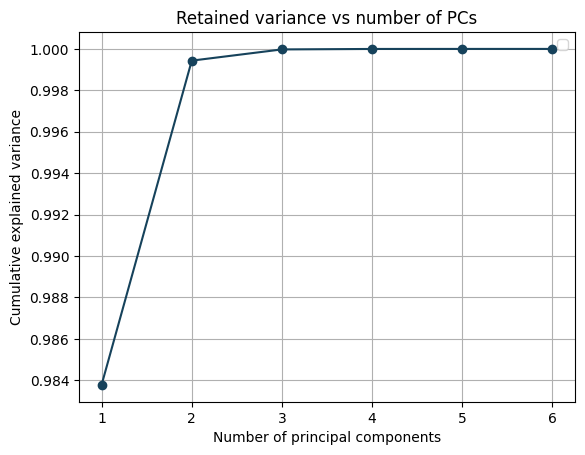

In [18]:
# After fitting PCA
ratios = pca.explained_variance_ratio_
cum_var = np.cumsum(ratios)

plt.figure()
plt.plot(np.arange(1, len(cum_var) + 1), cum_var, marker="o", color=INDIGO)
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("Retained variance vs number of PCs")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
idx = collated_inputs.sample(n=n_retained_rows, random_state=42).index
collated_inputs = collated_inputs.loc[idx]
collated_outputs = collated_outputs.loc[idx]

In [20]:
collated_inputs.to_csv(f"{data_directory}{os.sep}{input_filename}.csv", index=False)
collated_outputs.to_csv(f"{data_directory}{os.sep}{output_filename}.csv", index=False)
pd.DataFrame(pca_matrix).to_csv(f"{data_directory}{os.sep}{pca_filename}.csv", index=False)

In [21]:
collated_inputs = pd.read_csv(f"{data_directory}{os.sep}{input_filename}.csv")
collated_outputs = pd.read_csv(f"{data_directory}{os.sep}{output_filename}.csv")
pca_matrix = pd.read_csv(f"{data_directory}{os.sep}{pca_filename}.csv")

In [22]:
# Upload the resources
try:
    client.resources.upload(
        project_id=client.projects.get_project_id_by_name(PROJECT_NAME),
        name=input_filename,
        resource_type="dataset",
        file_path=f"{data_directory}{os.sep}{input_filename}.csv",
    )
except Exception as e:
    print(f"Dataset ({input_filename}) already exists, updating.")
    client.resources.update(
        project_id=client.projects.get_project_id_by_name(PROJECT_NAME),
        resource_id=client.resources.get_resource_id_by_name(
            project_id=client.projects.get_project_id_by_name(PROJECT_NAME), 
            name=input_filename,
            resource_type="dataset"
        ),
        resource_type="dataset",
        file_path=f"{data_directory}{os.sep}{input_filename}.csv",
    )
try:
    client.resources.upload(
        project_id=client.projects.get_project_id_by_name(PROJECT_NAME),
        name=output_filename,
        resource_type="dataset",
        file_path=f"{data_directory}{os.sep}{output_filename}.csv",
    )
except Exception as e:
    print(f"Dataset ({output_filename}) already exists, updating.")
    client.resources.update(
        project_id=client.projects.get_project_id_by_name(PROJECT_NAME),
        resource_id=client.resources.get_resource_id_by_name(
            project_id=client.projects.get_project_id_by_name(PROJECT_NAME), 
            name=output_filename,
            resource_type="dataset"
        ),
        resource_type="dataset",
        file_path=f"{data_directory}{os.sep}{output_filename}.csv",
    )


Dataset (collated_inputs) already exists, updating.
Dataset (collated_outputs) already exists, updating.


# 2. Training The Models

Define the training workflow that fits a GP per latent dimension and exports TorchScript, then run it for each output column.


In [23]:
from uncertainty_engine.nodes.base import Node
from uncertainty_engine.nodes.resource_management import LoadDataset
from uncertainty_engine.graph import Graph
from uncertainty_engine.nodes.workflow import Workflow

def get_presigned_url(url):
    """
    Get the contents from the presigned url.
    """
    url = url.replace("https://", "http://")
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for HTTP errors
    return response

def train_export_torchscript_workflow(
                    client,
                   project_name: str,
                   input_dataset_name: str,
                   output_dataset_name: str,
                    output_column_name: str,
                   save_model_name: str,
                   is_visualise_workflow: bool = False,
                   is_print_full_output: bool = False) -> dict:
    """
    A workflow that trains a machine learning model.
    Here, we assume all resources have already been uploaded to the cloud.
    :param client: The Uncertainty Engine client.
    :param project_name: The name of the project.
    :param dataset_name: The name of the dataset.
    :param input_names: The names of the input columns.
    :param output_names: The names of the output columns.
    :param save_model_name: The name to save the trained model as.
    :param is_visualise_workflow: Whether to print the workflow graph.
    :param is_print_full_output: Whether to print the full output of the workflow.
    :return: The response from running the workflow.
    """
    # 1. Create the graph
    graph = Graph()

    # 2. Create relevant nodes, handles, and add to graph:

    # 2.a. Load input dataset node
    load_input_data = LoadDataset(
        label="Load Input Dataset",
        file_id=client.resources.get_resource_id_by_name(
            name=input_dataset_name,
            project_id=client.projects.get_project_id_by_name(project_name),
            resource_type='dataset'
        ),
        project_id=client.projects.get_project_id_by_name(project_name),
        client=client,
    )
    graph.add_node(load_input_data)  # add to graph
    input_dataset = load_input_data.make_handle("file")  # add handle

    # 2.b. Load output dataset node
    load_output_data = LoadDataset(
        label="Load Output Dataset",
        file_id=client.resources.get_resource_id_by_name(
            name=output_dataset_name,
            project_id=client.projects.get_project_id_by_name(project_name),
            resource_type='dataset'
        ),
        project_id=client.projects.get_project_id_by_name(project_name),
        client=client,
    )
    graph.add_node(load_output_data)  # add to graph
    output_dataset = load_output_data.make_handle("file")  # add handle

    # 2.c. Filter dataset node for outputs
    output_dataset_column = Node(
        node_name="FilterDataset",
        label="Output Dataset",
        columns=[output_column_name],
        dataset=output_dataset,
        client=client,
    )
    graph.add_node(output_dataset_column)  # add to graph
    output_dataset_columns = output_dataset_column.make_handle("dataset")  # add handle

    # 2.d. Model config node
    model_config = Node(
        node_name="ModelConfig",
        label="Model Config",
        # model_type="SingleTaskVariationalGPTorch",
        client=client,
    )
    graph.add_node(model_config)  # add to graph
    output_config = model_config.make_handle("config")  # add handle

    # 2.e. Train model node
    train_model = Node(
        node_name="TrainModel",
        label="Train Model",
        config=output_config,
        inputs=input_dataset,
        outputs=output_dataset_columns,
        client=client,
    )
    graph.add_node(train_model)  # add to graph
    output_model = train_model.make_handle("model")  # add handle

    # 2.f. Save model node
    save = Node(
        node_name="Save",
        label="Save",
        data=output_model,
        file_id=save_model_name,
        project_id=client.projects.get_project_id_by_name(project_name),
        client=client,
    )
    graph.add_node(save)  # add to graph

    # 2.g. Export torchscript node
    export = Node(
        node_name="ExportTorchScript",
        label="ExportTorchScript",
        model=output_model,
        validation_inputs=input_dataset,
        client=client,
    )
    graph.add_node(export)  # add to graph
    export_model = export.make_handle("torch_script")  # add handle

    # 2.h. Download node
    download = Node(
        node_name="Download",
        label="Download",
        file=export_model,
        name=save_model_name,
        client=client,
    )
    graph.add_node(download)  # add to graph
    if is_visualise_workflow:
        pprint(graph.nodes)

    workflow = Workflow(
        graph=graph.nodes,
        inputs=graph.external_input,
        external_input_id=graph.external_input_id,
        requested_output={
            "Torchscript": download.make_handle("file").model_dump(),
          # "Torchscript": download,
        },
        client=client
        )
    try:
        client.workflows.save(
          project_id=client.projects.get_project_id_by_name(project_name),
          workflow=workflow,
          workflow_name="TrainModelExportTorchscriptModel",
        )
    except Exception as e:
        print(e)
        client.workflows.delete_workflow(
          project_id=client.projects.get_project_id_by_name(project_name),
          workflow_id=client.workflows.get_workflow_id_by_name(
              project_id=client.projects.get_project_id_by_name(project_name),
              name="TrainModelExportTorchscriptModel"
          ),
        )
        client.workflows.save(
          project_id=client.projects.get_project_id_by_name(project_name),
          workflow=workflow,
          workflow_name="TrainModelExportTorchscriptModel",
        )

    response = client.run_node(workflow)
    if is_print_full_output:
        pprint(response.model_dump())

    try:
        urllib.request.urlretrieve(response.outputs["outputs"]["Torchscript"],
                                    f"{models_directory}{os.sep}{save_model_name}.pt")
        print(f"Saved model: {models_directory}{os.sep}{save_model_name}.pt")
    except Exception as e:
        print(e)

    return response.outputs

In [24]:
for cn, mn in zip(output_column_names, save_model_names):
    print(f"Modelling output: {cn}")
    response = train_export_torchscript_workflow(
        client=client,
        project_name=PROJECT_NAME,
        input_dataset_name=input_filename,
        output_dataset_name=output_filename,
        output_column_name=cn,
        save_model_name=mn,
        is_visualise_workflow=False,
        is_print_full_output=False
    )

Modelling output: T_latent_0
Error creating workflow record: API Error: Bad Request
Details: Duplicate workflow name: A WorkflowRecord with name TrainModelExportTorchscriptModel already exists in the project.
Workflow 696b85c776e00c67b0841c37 deleted successfully from project 68dd8860e889afed3bc941a0.
Saved model: models/T_latent_0.pt
Modelling output: T_latent_1
Error creating workflow record: API Error: Bad Request
Details: Duplicate workflow name: A WorkflowRecord with name TrainModelExportTorchscriptModel already exists in the project.
Workflow 6983155a76e00c67b0842736 deleted successfully from project 68dd8860e889afed3bc941a0.
Saved model: models/T_latent_1.pt
Modelling output: T_latent_2
Error creating workflow record: API Error: Bad Request
Details: Duplicate workflow name: A WorkflowRecord with name TrainModelExportTorchscriptModel already exists in the project.
Workflow 6983158376e00c67b084273a deleted successfully from project 68dd8860e889afed3bc941a0.
Saved model: models/T_l

# 3. Model

Load the exported models, wrap them in a combined predictor and FMU, run a validation rollout, and visualise results with time-series and 3D views.


In [25]:
class Model:
    def __init__(
            self,
            model_path: str) -> torch.jit.ScriptModule:
        """
        Load a TorchScript model from disk.

        Parameters
        ----------
        model_path : str
            Path to the saved TorchScript model (.pt/.pth/.torch).

        Returns
        -------
        torch.jit.ScriptModule
            The loaded and ready-to-use model.
        """
        model = torch.jit.load(model_path, map_location="cpu")
        model.eval()
        self.model = model


    def __call__(
            self,
        prediction_points: np.ndarray,
        return_dict: bool = False
    ) -> Union[
        Tuple[np.ndarray, np.ndarray],
        Dict[str, np.ndarray]
    ]:
        """
        Run prediction on a TorchScript model using NumPy input.

        Converts the input NumPy array into a float32 tensor, performs inference,
        and converts the model outputs (prediction, uncertainty) back to NumPy.

        Parameters
        ----------
        model : torch.jit.ScriptModule
            A loaded TorchScript model.
            The model is assumed to return a tuple of tensors: (prediction, uncertainty)

        prediction_points : np.ndarray
            Input data with shape (N, D).
            Will be converted to a torch.float32 tensor.

        return_dict : bool, optional
            If True, returns {"prediction": ..., "uncertainty": ...}.
            If False (default), returns (prediction, uncertainty) as a tuple.

        Returns
        -------
        dict or tuple
            If return_dict=True:
                {
                    "prediction": np.ndarray,
                    "uncertainty": np.ndarray
                }
            Else:
                (prediction: np.ndarray, uncertainty: np.ndarray)
        """
        # Convert input NumPy array into a tensor
        x = torch.tensor(prediction_points, dtype=torch.float32)
        model = self.model

        model.eval()
        with torch.no_grad():
            y_pred = model(x)  # expected: (prediction_tensor, uncertainty_tensor)

        # Convert model outputs to NumPy
        prediction_np, uncertainty_np = (
            t.detach().cpu().numpy() for t in y_pred
        )

        if return_dict:
            return {
                "prediction": prediction_np,
                "uncertainty": uncertainty_np
            }

        return prediction_np, uncertainty_np


class CombinedModel:
    def __init__(self, model_filepaths):
        self.models = [Model(model_path=fp) for fp in model_filepaths]

    def __call__(self, prediction_points, return_dict=False):
        predictions = []
        uncertainties = []
        for model in self.models:
            pred, uncert = model(prediction_points, return_dict=False)
            predictions.append(pred)
            uncertainties.append(uncert)

        # Combine predictions and uncertainties (e.g., by averaging)
        combined_prediction = np.hstack(predictions)
        combined_uncertainty = np.hstack(uncertainties)

        if return_dict:
            return {
                "prediction": combined_prediction,
                "uncertainty": combined_uncertainty
            }

        return combined_prediction, combined_uncertainty



In [26]:
@dataclass
class HDI:
    low: np.ndarray   # (n_vertices,)
    high: np.ndarray  # (n_vertices,)


class FMU:
    """
    FMU for temperature evolution using a GP in latent space, while tracking:
      - a single "mean track" in FULL temperature space (current_temp_mean)
      - an ensemble of n_mc particles in FULL temperature space (current_temp_particles)

    The GP is used in latent space:
        inputs : [convective_coef, heat_flux, ambient_temp, latent_state_at_t_minus_lag]
        outputs: latent_state_at_current_time (predictive mean + predictive std)

    At each step:
      - For the mean track: query GP at lagged mean latent, then draw 1 sample.
      - For each particle: query GP at its lagged latent, then draw 1 sample.
      - Map latent samples -> full temperature via backward_matrix.

    Notes
    -----
    - This is *not* a Gaussian propagation. We explicitly sample.
    - Lagging requires interpolating latent states through time; we therefore store
      latent histories for mean and particles.
    - Particles live in FULL space, but lag interpolation is done in LATENT space
      (cheaper & consistent with the model input).

    Parameters
    ----------
    model : callable
        Must support:
            mu, std = model(prediction_points=features)
        where mu,std are arrays of shape (n_latent,) or (1, n_latent)
        representing predictive mean and predictive std (per latent dim).
    pca_matrix : np.ndarray
        This is your backward_matrix mapping latent -> full:
            T = z @ backward_matrix
        Shape: (n_latent, n_vertices)
        The forward_matrix is taken as backward_matrix.T.
    initial_input_state : np.ndarray
        Shape (3,): [Convection_FilmCoef, Heat Flux_Magnitude, Convection_AmbientTemp]
    initial_temp_state : np.ndarray
        Shape (n_vertices,)
    lag_s : float
        Lag (seconds) used in the GP input.
    n_mc : int
        Number of particles in FULL space to track.
    random_state : int | None
        RNG seed.
    """

    def __init__(
        self,
        model,
        pca_matrix: np.ndarray,
        initial_input_state: np.ndarray,
        initial_temp_state: np.ndarray,
        lag_s: float = 0.1,
        n_mc: int = 32,
        random_state: int | None = 42,
    ):
        self.model = model

        self.backward_matrix = np.asarray(pca_matrix, dtype=float)          # (n_latent, n_vertices)
        self.forward_matrix = self.backward_matrix.T                        # (n_vertices, n_latent)

        self.n_mc = int(n_mc)
        if self.n_mc < 1:
            raise ValueError(f"n_mc must be >= 1, got {n_mc}")

        self.rng = np.random.default_rng(random_state)

        # Time and lag
        self.current_time = 0.0
        self.lag_s = float(lag_s)

        # Inputs
        self.current_input_state = np.asarray(initial_input_state, dtype=float).copy()

        # FULL space: mean + particles
        initial_temp_state = np.asarray(initial_temp_state, dtype=float).copy()
        self.current_temp_mean = initial_temp_state                         # (n_vertices,)
        self.current_temp_particles = np.repeat(
            initial_temp_state[None, :], repeats=self.n_mc, axis=0
        )                                                                    # (n_mc, n_vertices)

        # LATENT space current states (for lagging + GP input)
        self.current_latent_mean = self.current_temp_mean @ self.forward_matrix           # (n_latent,)
        self.current_latent_particles = self.current_temp_particles @ self.forward_matrix # (n_mc, n_latent)

        # Histories for interpolation at (t - lag)
        self.times: list[float] = [self.current_time]

        self.latent_mean_history: list[np.ndarray] = [self.current_latent_mean.copy()]
        self.latent_particles_history: list[np.ndarray] = [self.current_latent_particles.copy()]

    # ---------------------------------------------------------------------
    # Interpolation helpers
    # ---------------------------------------------------------------------

    @staticmethod
    def _interp_vector_history(t_query: float, times: list[float], values: list[np.ndarray]) -> np.ndarray:
        """
        Linear interpolation of vector-valued history.
        values[k] must be same shape for all k.

        Clamps at ends.
        """
        if t_query <= times[0]:
            return values[0].copy()
        if t_query >= times[-1]:
            return values[-1].copy()

        idx = bisect_right(times, t_query) - 1
        t0, t1 = times[idx], times[idx + 1]
        v0, v1 = values[idx], values[idx + 1]

        if t1 == t0:
            return v0.copy()

        w = (t_query - t0) / (t1 - t0)
        return (1.0 - w) * v0 + w * v1

    def _latent_mean_at(self, t_query: float) -> np.ndarray:
        return self._interp_vector_history(t_query, self.times, self.latent_mean_history)

    def _latent_particles_at(self, t_query: float) -> np.ndarray:
        return self._interp_vector_history(t_query, self.times, self.latent_particles_history)

    # ---------------------------------------------------------------------
    # GP sampling helper
    # ---------------------------------------------------------------------

    def _gp_sample_latent_next(self, new_input_state: np.ndarray, z_lag: np.ndarray) -> np.ndarray:
        """
        Query GP at [u, z_lag] and draw one sample from predictive distribution.

        Returns: z_next sample, shape (n_latent,)
        """
        features = np.hstack([new_input_state, z_lag])
        mu, std = self.model(prediction_points=features)

        mu = np.asarray(mu, dtype=float).reshape(-1)
        std = np.asarray(std, dtype=float).reshape(-1)

        if mu.shape != std.shape:
            raise ValueError(f"model returned mu shape {mu.shape} and std shape {std.shape}, expected same")

        eps = self.rng.standard_normal(size=mu.shape[0])
        return mu + std * eps

    # ---------------------------------------------------------------------
    # Main step
    # ---------------------------------------------------------------------

    def __call__(self, new_input_state: np.ndarray, time_step: float):
        """
        Advance FMU by one step.

        Returns
        -------
        current_temp_mean : (n_vertices,)
            Updated mean-track temperature (one GP sample from mean-track input).
        current_temp_particles : (n_mc, n_vertices)
            Updated particle ensemble in full space.
        """
        dt = float(time_step)
        if dt <= 0.0:
            raise ValueError(f"time_step must be positive, got {dt}")

        new_input_state = np.asarray(new_input_state, dtype=float).copy()
        new_time = self.current_time + dt

        # Where we need the latent "memory"
        t_lag = new_time - self.lag_s

        # ---- Mean track update (latent) ----
        z_lag_mean = self._latent_mean_at(t_lag)                    # (n_latent,)
        z_next_mean, _ = self.model(prediction_points=np.hstack([new_input_state, z_lag_mean]))
        z_next_mean = z_next_mean.reshape(-1)
        # ---- Particle updates (latent) ----
        z_lag_particles = self._latent_particles_at(t_lag)          # (n_mc, n_latent)
        if z_lag_particles.shape[0] != self.n_mc:
            raise ValueError(
                f"latent_particles_at(t) returned shape {z_lag_particles.shape}, expected (n_mc, n_latent)"
            )

        z_next_particles = np.empty_like(z_lag_particles)
        for i in range(self.n_mc):
            z_next_particles[i] = self._gp_sample_latent_next(new_input_state, z_lag_particles[i])

        # ---- Map latent -> full temperature ----
        temp_mean = z_next_mean @ self.backward_matrix              # (n_vertices,)
        temp_particles = z_next_particles @ self.backward_matrix    # (n_mc, n_vertices)

        # ---- Commit state ----
        self.current_time = new_time
        self.current_input_state = new_input_state

        self.current_latent_mean = z_next_mean
        self.current_latent_particles = z_next_particles

        self.current_temp_mean = temp_mean
        self.current_temp_particles = temp_particles

        # ---- Append histories (for future lag interpolation) ----
        self.times.append(new_time)
        self.latent_mean_history.append(self.current_latent_mean.copy())
        self.latent_particles_history.append(self.current_latent_particles.copy())

        return self.current_temp_mean, self.current_temp_particles

    # ---------------------------------------------------------------------
    # HDI methods (full space)
    # ---------------------------------------------------------------------

    @staticmethod
    def _hdi_from_particles(samples: np.ndarray, mass: float = 0.95, axis: int = 0) -> tuple[np.ndarray, np.ndarray]:
        """
        Highest Density Interval (HDI) along `axis` using the narrowest interval
        containing `mass` fraction of samples.

        samples shape: (n_mc, ...) where axis=0 typically indexes particles.
        Returns: (low, high) arrays with shape equal to samples.shape with axis removed.
        """
        if not (0.0 < mass < 1.0):
            raise ValueError("mass must be in (0, 1)")

        x = np.moveaxis(np.asarray(samples), axis, 0)  # sample axis -> 0
        n = x.shape[0]
        if n < 2:
            lo = np.squeeze(x, axis=0)
            hi = np.squeeze(x, axis=0)
            return lo, hi

        m = int(np.floor(mass * n))
        m = max(1, min(m, n - 1))

        xs = np.sort(x, axis=0)
        widths = xs[m:, ...] - xs[:-m, ...]         # (n-m, ...)
        idx = np.argmin(widths, axis=0)             # (...)

        grid = np.indices(idx.shape)
        lo = xs[(idx, *grid)]
        hi = xs[(idx + m, *grid)]
        return lo, hi

    def current_hdi(self, mass: float = 0.95) -> HDI:
        """
        95% HDI (or other mass) at the current time, per vertex, from FULL-space particles.

        Returns
        -------
        HDI(low=(n_vertices,), high=(n_vertices,))
        """
        lo, hi = self._hdi_from_particles(self.current_temp_particles, mass=mass, axis=0)
        return HDI(low=lo, high=hi)

    def current_hdi_halfwidth(self, mass: float = 0.95) -> np.ndarray:
        """
        Convenience: half-width of the HDI interval per vertex.
        """
        h = self.current_hdi(mass=mass)
        return 0.5 * (h.high - h.low)


In [27]:
models = [f"{models_directory}{os.sep}{mn}.pt" for mn in save_model_names]
model = CombinedModel(model_filepaths=models)

In [ ]:
val_number = 19

val_in = pd.read_csv(f"{raw_data_directory}{os.sep}Scenario_{val_number}_exc.csv")
val_out = pd.read_csv(f"{raw_data_directory}{os.sep}Scenario_{val_number}_out.csv")
val_in.columns = val_in.columns.str.strip()
val_out.columns = val_out.columns.str.strip()

times = val_in['Time'].to_numpy()
val_inputs = val_in[external_conditions_input_names].to_numpy()
cols = [str(x) for x in range(1, 4961)]
val_starting_temp = val_out[cols].to_numpy()[0]

time_steps = times[1:] - times[:-1]

In [37]:
fmu = FMU(
    model=model,
    pca_matrix=pca_matrix,
    initial_input_state=val_inputs[0],
    initial_temp_state=val_starting_temp,
    lag_s=lag_time,
)


In [38]:
output_states = []
output_states_low = []
output_states_high = []
for new, t_step in zip(val_inputs[1:], time_steps):
    T_mean, T_particles = fmu(new_input_state=new, time_step=t_step)

    hdi = fmu.current_hdi()

    output_states.append(T_mean)
    output_states_low.append(hdi.low)
    output_states_high.append(hdi.high)

In [39]:
predictions = np.array(output_states)
prediction_lower_bounds = np.array(output_states_low)
prediction_upper_bounds = np.array(output_states_high)

In [40]:
times_plot = times[1:]
prediction_uncertainties = 0.5 * (prediction_upper_bounds - prediction_lower_bounds)

ground_truths = val_out[cols].to_numpy()[1:]
output_errors = np.abs(predictions - ground_truths)

percentage_errors = 100. * output_errors / ground_truths
percentage_uncertainties = 100. * prediction_uncertainties / ground_truths

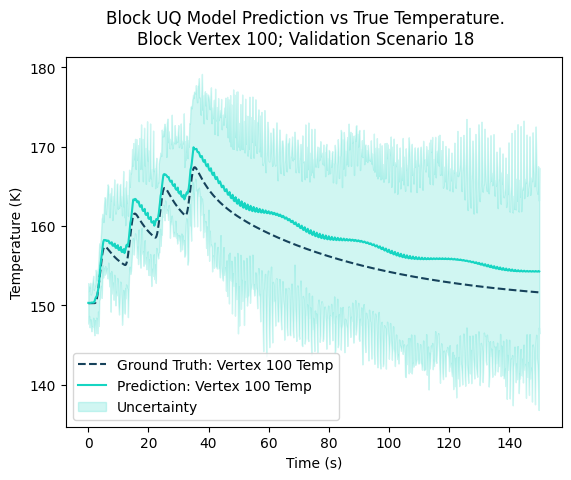

In [41]:
plot_vertex = 100

plt.plot(times_plot, ground_truths[:, plot_vertex], color=INDIGO, label=f"Ground Truth: Vertex {plot_vertex} Temp", linestyle='dashed')
plt.plot(times_plot, predictions[:, plot_vertex], color=KEPPEL, label=f"Prediction: Vertex {plot_vertex} Temp")
plt.fill_between(times_plot,
                 prediction_lower_bounds[:, plot_vertex],
                 prediction_upper_bounds[:, plot_vertex],
                 color=KEPPEL, alpha=0.2, label="Uncertainty")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.suptitle(f"Block UQ Model Prediction vs True Temperature.\nBlock Vertex {plot_vertex}; Validation Scenario {val_number}")
plt.legend()
plt.show()


In [42]:
# ----------------------------
# Extract + locate ds.dat
# ----------------------------
def _extract_wbpz(wbpz_path, out_dir=None):
    wbpz_path = Path(wbpz_path)
    if out_dir is None:
        out_dir = Path(tempfile.mkdtemp(prefix=wbpz_path.stem + "_"))
    else:
        out_dir = Path(out_dir)
        out_dir.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(wbpz_path, "r") as z:
        z.extractall(out_dir)
    return out_dir

def _find_ds_dat(extracted_root: Path):
    hits = list(Path(extracted_root).rglob("ds.dat"))
    if not hits:
        raise FileNotFoundError("Could not find ds.dat inside extracted wbpz.")
    return hits[0]


# ----------------------------
# NBLOCK (nodes)
# ----------------------------
def _read_nblock_points(ds_dat: Path):
    """
    Returns:
      node_ids: (N,)
      pts:      (N,3)
    """
    lines = ds_dat.read_text(errors="ignore").splitlines()
    i0 = next((i for i, l in enumerate(lines) if l.lower().startswith("nblock")), None)
    if i0 is None:
        raise ValueError("NBLOCK not found in ds.dat")

    i = i0 + 2  # skip NBLOCK line + format line
    node_ids, pts = [], []

    while i < len(lines):
        s = lines[i].strip()
        if s.startswith("-1"):
            break
        parts = s.split()
        if len(parts) >= 4:
            node_ids.append(int(parts[0]))
            pts.append([float(parts[1]), float(parts[2]), float(parts[3])])
        i += 1

    return np.asarray(node_ids, dtype=int), np.asarray(pts, dtype=float)


# ----------------------------
# EBLOCK (elements)
# ----------------------------
_INT_RE = re.compile(r"^-?\d+$")

def _tokenize_ints(line: str):
    # robust-ish tokenization for ds.dat
    out = []
    for tok in line.strip().split():
        if _INT_RE.match(tok):
            out.append(int(tok))
    return out

def _read_eblock_elements(ds_dat: Path):
    """
    Very practical EBLOCK reader for common ANSYS solids.

    Returns:
      elements: list of node-id lists, one per element

    Notes:
      EBLOCK formatting varies. This parser uses a heuristic:
      - read integers from each line
      - treat the *tail* as connectivity
      - accept connectivity lengths of 4, 8, 10, 20 (common solid element orders)

    If your EBLOCK is multi-line-per-element, this still works because we
    accumulate until we hit a plausible connectivity length.
    """
    lines = ds_dat.read_text(errors="ignore").splitlines()
    i0 = next((i for i, l in enumerate(lines) if l.lower().startswith("eblock")), None)
    if i0 is None:
        raise ValueError("EBLOCK not found in ds.dat")

    i = i0 + 1
    elements = []

    buf = []  # rolling buffer of ints for current element(s)

    # plausible connectivity sizes we’ll accept
    # 4=tet4, 8=hex8, 10=tet10, 20=hex20 (common)
    plausible = {4, 8, 10, 20}

    while i < len(lines):
        s = lines[i].strip()
        if s.startswith("-1"):
            break

        ints = _tokenize_ints(s)
        if ints:
            buf.extend(ints)

            # Heuristic: connectivity node IDs are positive.
            # We try to peel off a plausible connectivity from the end.
            # We allow multiple elements to be encoded in buffer.
            made_progress = True
            while made_progress:
                made_progress = False

                # Try each plausible connectivity size, starting large → small
                for k in sorted(plausible, reverse=True):
                    if len(buf) >= k:
                        tail = buf[-k:]
                        if all(v > 0 for v in tail):
                            # accept as one element connectivity
                            elements.append(tail)
                            # remove the consumed tail; keep remaining for next
                            buf = buf[:-k]
                            made_progress = True
                            break

        i += 1

    if not elements:
        raise ValueError("Parsed EBLOCK but found 0 elements. EBLOCK format may be different; we can refine the parser.")

    return elements


# ----------------------------
# Build PyVista UnstructuredGrid
# ----------------------------
def build_unstructured_grid_from_ansys(node_ids, points, elements):
    """
    node_ids: (N,) global node ids
    points:   (N,3)
    elements: list[list[int]] connectivity in node IDs

    Returns:
      pv.UnstructuredGrid
    """
    id_to_idx = {nid: i for i, nid in enumerate(node_ids)}

    cells_list = []
    types_list = []

    for conn_ids in elements:
        try:
            conn = [id_to_idx[n] for n in conn_ids]
        except KeyError:
            # element references node not in NBLOCK subset; skip
            continue

        nn = len(conn)
        if nn == 4:
            cell_type = pv.CellType.TETRA
        elif nn == 8:
            cell_type = pv.CellType.HEXAHEDRON
        elif nn == 10:
            cell_type = pv.CellType.QUADRATIC_TETRA
        elif nn == 20:
            cell_type = pv.CellType.QUADRATIC_HEXAHEDRON
        else:
            # ignore unusual types for now
            continue

        cells_list.append([nn] + conn)
        types_list.append(cell_type)

    if not cells_list:
        raise ValueError("No cells were constructed. Check node ID mapping / EBLOCK parsing.")

    # VTK expects a flat array: [npts, p0, p1, ..., npts, p0, ...]
    cells = np.array([v for cell in cells_list for v in cell], dtype=np.int64)
    celltypes = np.array(types_list, dtype=np.uint8)

    grid = pv.UnstructuredGrid(cells, celltypes, np.asarray(points, dtype=float))
    return grid


# ----------------------------
# Load full mesh from WBZP
# ----------------------------
def load_mesh_from_wbpz(wbpz_path, N_expected=None):
    root = _extract_wbpz(wbpz_path)
    ds_dat = _find_ds_dat(root)

    node_ids, pts_all = _read_nblock_points(ds_dat)

    # If your arrays are defined for node IDs 1..N, keep that subset (common)
    if N_expected is not None:
        sel = (node_ids >= 1) & (node_ids <= int(N_expected))
        node_ids = node_ids[sel]
        pts_all = pts_all[sel]

    elements = _read_eblock_elements(ds_dat)

    grid = build_unstructured_grid_from_ansys(node_ids, pts_all, elements)
    return grid


# ----------------------------
# Export VTU time series on a real mesh
# ----------------------------
def export_mesh_timeseries_paraview(
    out_dir,
    times_plot,
    grid_template: pv.UnstructuredGrid,
    ground_truths,
    predictions,
    percentage_errors,
    percentage_uncertainties,
    base_filename="step",
):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    times = np.asarray(times_plot, dtype=float)
    T = len(times)
    N = grid_template.n_points

    def as_TN(x, name):
        arr = np.asarray(x)
        if arr.shape[0] != T:
            raise ValueError(f"{name} must have length T={T} in axis 0, got shape {arr.shape}")
        if arr.shape[1] != N:
            raise ValueError(f"{name} must be (T,N) with N={N}, got {arr.shape}")
        return arr

    gt = as_TN(ground_truths, "ground_truths")
    pr = as_TN(predictions, "predictions")
    pe = as_TN(percentage_errors, "percentage_errors")
    pu = as_TN(percentage_uncertainties, "percentage_uncertainties")

    files = []
    for i in range(T):
        g = grid_template.copy(deep=True)
        g.point_data["ground_truth"] = gt[i].astype(np.float32, copy=False)
        g.point_data["prediction"] = pr[i].astype(np.float32, copy=False)
        g.point_data["percentage_error"] = pe[i].astype(np.float32, copy=False)
        g.point_data["percentage_uncertainty"] = pu[i].astype(np.float32, copy=False)
        g.field_data["time"] = np.array([times[i]], dtype=np.float64)

        fname = out_dir / f"{base_filename}_{i:05d}.vtu"
        g.save(fname)
        files.append(fname)

    # Write PVD
    pvd_path = out_dir / "series.pvd"
    lines = [
        '<?xml version="1.0"?>',
        '<VTKFile type="Collection" version="0.1" byte_order="LittleEndian">',
        '  <Collection>',
    ]
    for i, t in enumerate(times):
        rel = f"{base_filename}_{i:05d}.vtu"
        lines.append(f'    <DataSet timestep="{float(t)}" group="" part="0" file="{rel}"/>')
    lines += ['  </Collection>', '</VTKFile>']
    pvd_path.write_text("\n".join(lines))

    return {"pvd_path": str(pvd_path), "files": [str(f) for f in files], "out_dir": str(out_dir)}


In [43]:
N = np.asarray(ground_truths[0]).ravel().size

grid = load_mesh_from_wbpz(box_details_filename, N_expected=N)

export = export_mesh_timeseries_paraview(
    out_dir=f"results_val_scenario_{val_number}",
    times_plot=times_plot,
    grid_template=grid,
    ground_truths=np.asarray(ground_truths),
    predictions=np.asarray(predictions),
    percentage_errors=np.asarray(percentage_errors),
    percentage_uncertainties=np.asarray(percentage_uncertainties),
)

print("Open in ParaView:", export["pvd_path"])


Open in ParaView: results_val_scenario_18/series.pvd
